In [1]:
import polars as pl
from polars import col as c
import matplotlib.pyplot as plt
import mplfinance as mpf
import ta
import numpy as np
import pandas as pd

In [88]:
d = pl.read_parquet('/shared/daily/krx/stocks_ohlcv_return_marketcap/all_adjusted.parquet')
d = d.filter(c('단축코드') == '017670').to_pandas()

d['rsi'] = ta.momentum.rsi(d['수정종가'])
d = d.set_index('날짜')

d = d.rename(columns={'수정종가':'close','수정시가':'open','수정고가':'high','수정저가':'low'})

d['lastclose'] = d['close'].shift(1)

d.index = pd.to_datetime(d.index)

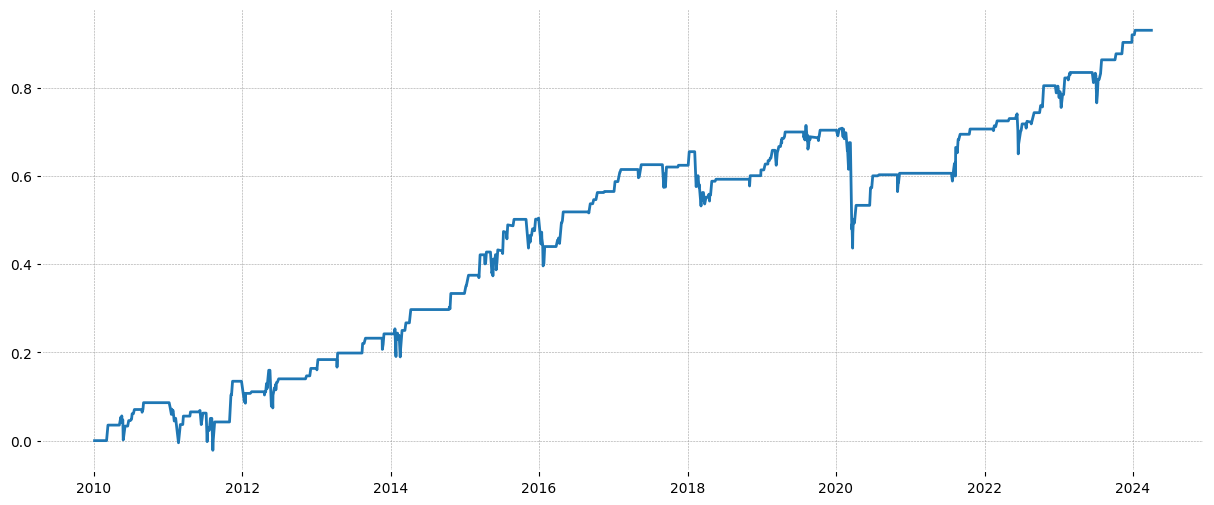

In [128]:


pos = 0
cum_rt = []

bidpoint = []
askpoint = []

for i,r in d.iterrows():
    cum_rt.append((r['close']/r['lastclose']-1)*pos)
    askpoint.append(np.nan)
    bidpoint.append(np.nan)
    if r['rsi'] < 40 and pos == 0:
        pos = 1
        bidpoint[-1] = 1
    elif r['rsi'] > 40 and pos > 0:
        pos = 0
        askpoint[-1] = 1

plt.figure(figsize=(15,6))
plt.plot(d.index,pd.DataFrame(cum_rt).cumsum())


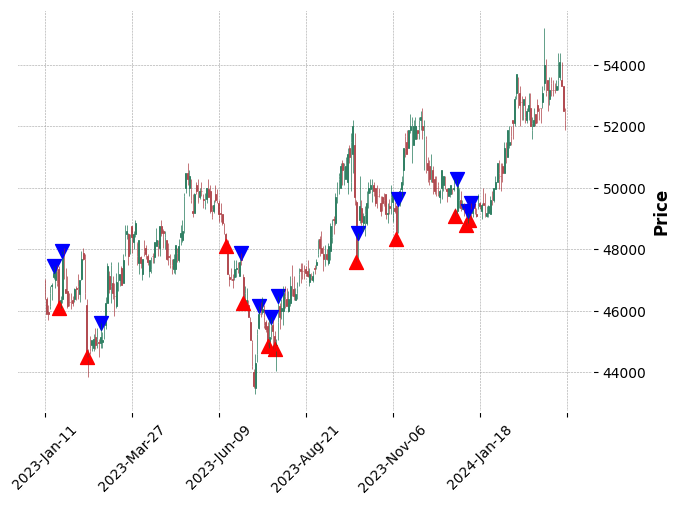

In [129]:
bid_series = d['low'].where(np.array(bidpoint) == 1,other=np.nan).iloc[-300:]
ask_series = d['high'].where(np.array(askpoint) == 1,other=np.nan).iloc[-300:]
ap = [mpf.make_addplot(bid_series, type='scatter', markersize=100, marker='^',color='r'),
    mpf.make_addplot(ask_series, type='scatter', markersize=100, marker='v',color='b')]

mpf.plot(d.iloc[-300:], type='candle', style='charles',addplot=ap)